In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt

In [2]:
# Function to preprocess data
def preprocess_data(data_path):
    data = pd.read_csv(data_path)
    data.columns = data.columns.str.strip()
    
    # Select features and target
    X = data[['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']]
    y = data['rainfall'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Feature scaling
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    return X, y

In [3]:
# Function to perform model training and evaluation
def train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name, output_file):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model and evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model_name} Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain", "Rain"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    # Save the model
    joblib.dump(best_model, output_file)
    print(f"{model_name} model saved as '{output_file}'\n")

    return accuracy

In [4]:
# Function to plot comparison of model accuracies
def plot_accuracies(algorithms, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(algorithms, accuracies, color=['blue', 'orange', 'green', 'red'])
    plt.ylim(0, 100)
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of Algorithm Accuracies')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Random Forest Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy: 78.38%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.54      0.62        24
           1       0.80      0.90      0.85        50

    accuracy                           0.78        74
   macro avg       0.76      0.72      0.73        74
weighted avg       0.78      0.78      0.77        74



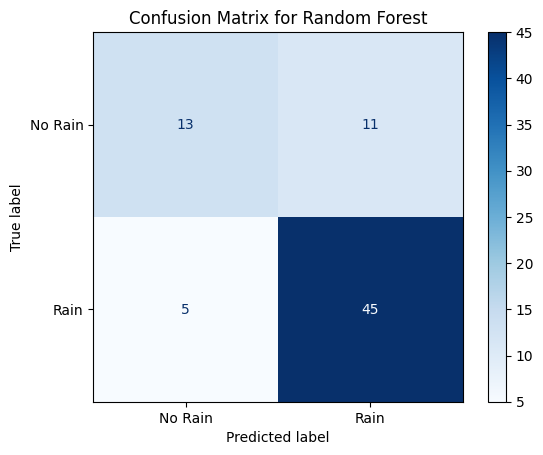

Random Forest model saved as 'rainfall_rf_model.pkl'

SVM Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
SVM Accuracy: 85.14%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73        24
           1       0.84      0.96      0.90        50

    accuracy                           0.85        74
   macro avg       0.86      0.79      0.81        74
weighted avg       0.86      0.85      0.84        74



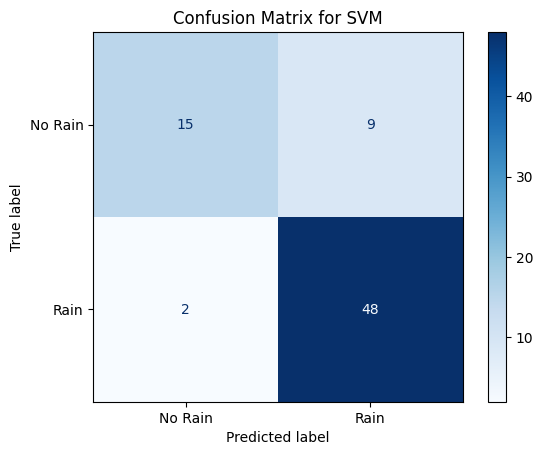

SVM model saved as 'rainfall_svm_model.pkl'

Gradient Boosting Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Gradient Boosting Accuracy: 79.73%
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        24
           1       0.82      0.90      0.86        50

    accuracy                           0.80        74
   macro avg       0.78      0.74      0.75        74
weighted avg       0.79      0.80      0.79        74



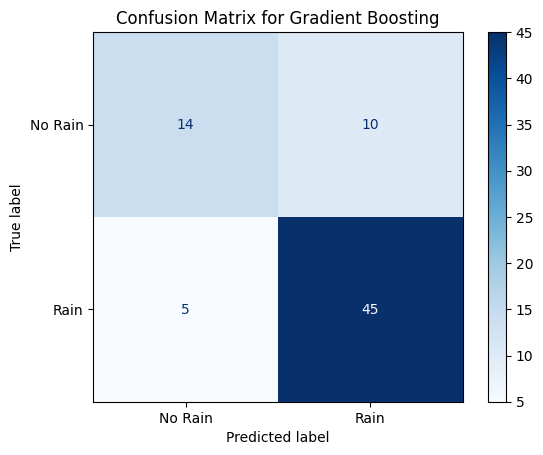

Gradient Boosting model saved as 'rainfall_gb_model.pkl'

Logistic Regression Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Accuracy: 82.43%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.50      0.65        24
           1       0.80      0.98      0.88        50

    accuracy                           0.82        74
   macro avg       0.86      0.74      0.77        74
weighted avg       0.84      0.82      0.81        74



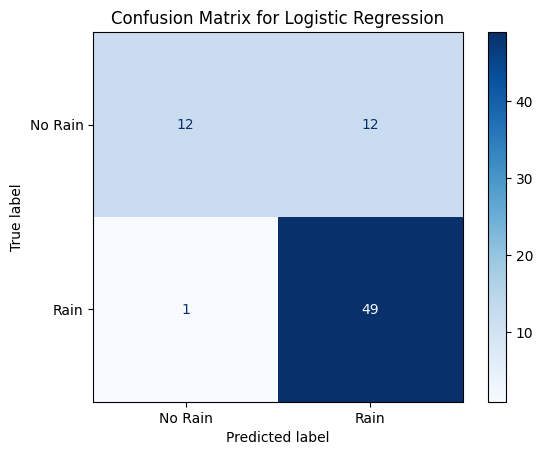

Logistic Regression model saved as 'rainfall_lr_model.pkl'



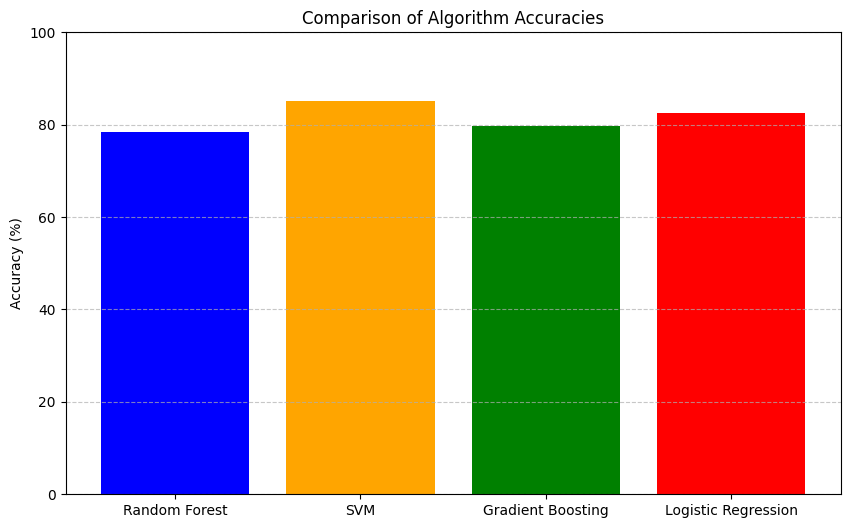

In [5]:
# Main script
if __name__ == "__main__":
    # Load and preprocess data
    data_path = "weather_data.csv"
    X, y = preprocess_data(data_path)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Models and parameters
    models = [
        (RandomForestClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }, "Random Forest", "rainfall_rf_model.pkl"),

        (SVC(random_state=42), {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': [1, 0.1, 0.01, 0.001]
        }, "SVM", "rainfall_svm_model.pkl"),

        (GradientBoostingClassifier(random_state=42), {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }, "Gradient Boosting", "rainfall_gb_model.pkl"),

        (LogisticRegression(max_iter=1000, random_state=42), {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }, "Logistic Regression", "rainfall_lr_model.pkl")
    ]

    accuracies = []

    for model, param_grid, model_name, output_file in models:
        accuracy = train_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, model_name, output_file)
        accuracies.append(accuracy * 100)

    # Plot model accuracies
    algorithms = [m[2] for m in models]
    plot_accuracies(algorithms, accuracies)